In [1]:
import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

import lightgbm as lgb
import matplotlib.pyplot as plt
import time
import seaborn as sns
from tqdm import tqdm as tqdm

In [2]:
f2 = pd.read_pickle('features/progress2.pkl')
f3 = pd.read_pickle('features/progress3.pkl')
f4 = pd.read_pickle('features/progress4.pkl')
f5 = pd.read_pickle('features/come_type.pkl')

In [3]:
f6 = pd.read_pickle('features/progress2_out.pkl')
f7 = pd.read_pickle('features/progress3_out.pkl')
f8 = pd.read_pickle('features/progress4_out.pkl')
f9 = pd.read_pickle('features/out_type.pkl')

In [4]:
weather = pd.read_pickle('features/weather.pkl')

In [5]:
# f5.fillna(0,inplace=True)
# f5['come_max_id'] = f5['come_max_id'].astype('str').apply(lambda x:x.split('_')[0]).astype('int')
# f5['come_out_max_id'] = f5['come_out_max_id'].astype('str').apply(lambda x:x.split('_')[0]).astype('int')

In [6]:
f4.shape

(933120, 12)

In [7]:
f9.shape

(933120, 15)

In [18]:
# 合并特征
filelist = [f2]
f = pd.DataFrame()
for file in tqdm(filelist):
    for c in file.columns:
        if c in f.columns:continue
        c_ = 'in_'+c
        f[c_] = list(file[c])
        if file.dtypes[c]=='object':
            f[c] = f[c].astype('float')
# 合并特征
filelist = [f6,f7,f8,f9]
for file in tqdm(filelist):
    for c in file.columns:
        c_ = c
        f[c_] = list(file[c])

100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


In [19]:
f9.shape

(933120, 15)

In [20]:
predictor2 = ['count_10min_all', 'count_30min_all',
       'count_2h_all', 'count_24h_all', 'count_10min_bystation',
       'count_30min_bystation', 'count_2h_bystation', 'count_24h_bystation',
       'count_24h_byminute', 'count_10min_near', 'count_30min_near',
       'count_2h_near', 'count_24h_near','median_30min_bystation']

In [21]:
f.columns

Index(['in_minute', 'in_stationID', 'in_count_10min_all', 'in_count_30min_all',
       'in_count_2h_all', 'in_count_24h_all', 'in_count_10min_bystation',
       'in_count_30min_bystation', 'in_count_2h_bystation',
       'in_count_24h_bystation', 'in_count_24h_byminute',
       'in_count_10min_near', 'in_count_30min_near', 'in_count_2h_near',
       'in_count_24h_near', 'in_week_th', 'in_weekday', 'in_date', 'minute',
       'stationID', 'count_10min_all', 'count_30min_all', 'count_2h_all',
       'count_24h_all', 'count_10min_bystation', 'count_30min_bystation',
       'count_2h_bystation', 'count_24h_bystation', 'count_24h_byminute',
       'count_10min_near', 'count_30min_near', 'count_2h_near',
       'count_24h_near', 'week_th', 'weekday', 'date',
       'median_30min_bystation', 'max_count_ID', 'count_10_max', 'device_num',
       'near_num', 'type_0_bystatiommin', 'type_1_bystatiommin',
       'type_2_bystatiommin', 'type_3_bystatiommin', 'type_0_bystatiom',
       'type_1_bysta

In [22]:
# 构建训练集
raw_predictor = [x for x in f.columns if x not in ['minute','stationID','in_minute','in_stationID',
                                                   'date','week_th']]
one_day = pd.DataFrame()
for d in tqdm([13,20,27]):
    try:
        label = list(f[f.date==d]['count_10min_bystation'])
    except:
        label = []

    if not label:
        label = -1
    base_info = f[f.date==20][['minute','stationID']]
    
    
    base_info['come_label'] = label
    
    for p in raw_predictor:
         base_info['y_'+p] = list(f[f.date==d-1][p])
    for p in raw_predictor:
         base_info['tomo_'+p] = list(f[f.date==d+1][p])
#     for p in predictor:
#         try:
#             base_info['lastweek_'+p] = list(f[f.date==d-7][p])
#         except:
#             base_info['lastweek_'+p] = -1
    
    base_info['date'] = d
    for c in ['max_t','min_t','air','weather']:
        base_info[c] = int(weather[weather.date==d][c].values[0])
    for c in ['max_t','min_t','air','weather']:
        base_info['y_'+c] = int(weather[weather.date==d-1][c].values[0])
    # 对应的周一出站情况
#     for p in predictor2:
#         if d in [3,4]:
#             base_info['first_'+p] = -1
#         if d in [8,9,10,11]:
#             base_info['first_'+p] = list(f[f.date==7][p])
#         if d in [15,16,17,18]:
#             base_info['first_'+p] = list(f[f.date==14][p])
#         if d in [22,23,24,25]:
#             base_info['first_'+p] = list(f[f.date==21][p])
#         if d in [29]:
#             base_info['first_'+p] = list(f[f.date==28][p])
        
    one_day = one_day.append(base_info)

100%|██████████| 3/3 [00:16<00:00,  5.23s/it]


In [23]:
train = one_day[(one_day.date.isin([13,20]))&(one_day.stationID!=54)]
train.reset_index(drop=True,inplace=True)
predictor = [x for x in one_day.columns if x not in ['come_label']]

In [24]:
# 构建训练集
raw_predictor = [x for x in f.columns if x not in ['minute','stationID','in_minute','in_stationID',
                                                   'date','week_th']]
one_day_v2 = pd.DataFrame()
for d in tqdm([19,20,26,27]):
    try:
        label = list(f[f.date==d]['count_10min_bystation'])
    except:
        label = []

    if not label:
        label = -1
    base_info = f[f.date==20][['minute','stationID']]
    
    base_info['come_label'] = label
    
#     for p in predictor:
#          base_info['y_'+p] = list(f[f.date==d-1][p])
#     for p in predictor:
#          base_info['tomo_'+p] = list(f[f.date==d+1][p])
    for p in raw_predictor:
        try:
            base_info['lastweek_'+p] = list(f[f.date==d-7][p])
        except:
            base_info['lastweek_'+p] = -1
    
    base_info['date'] = d
    for c in ['max_t','min_t','air','weather']:
        base_info[c] = int(weather[weather.date==d][c].values[0])
    for c in ['max_t','min_t','air','weather']:
        base_info['y_'+c] = int(weather[weather.date==d-1][c].values[0])
    one_day_v2 = one_day_v2.append(base_info)

100%|██████████| 4/4 [00:12<00:00,  3.13s/it]


In [25]:
train_v2 = one_day_v2[(one_day_v2.date.isin([19,20]))&(one_day_v2.stationID!=54)]
train_v2.reset_index(drop=True,inplace=True)
predictor_v2 = [x for x in one_day_v2.columns if x not in ['come_label']]

In [28]:
param = {'num_leaves': 32,
         'min_data_in_leaf': 5, 
         'objective':'mae',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'mae',
         "lambda_l1": 0.2634,
         "random_state": 133,
         'n_jobs':8,
         "verbosity": -1}

In [29]:
# for train
from sklearn.model_selection import KFold
num_round = 30000
kfold = KFold(random_state=1,n_splits=2,shuffle=False)
i = 0
for train_index,test_index in kfold.split(train):
    i+=1
    if i!=2:continue
    train_x,train_y = train.loc[train_index,predictor],train.loc[train_index,'come_label']
    valid_x,valid_y = train.loc[(test_index),predictor],train.loc[test_index,'come_label']
    valid_x = valid_x[valid_x.minute.isin(set(range(144)))]
    valid_y = valid_y[valid_x.index]
    trn_data = lgb.Dataset(train_x,label=train_y)
    val_data = lgb.Dataset(valid_x,label=valid_y)
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data,val_data],
                    verbose_eval=500,
                   early_stopping_rounds=500)
    pred1 = clf.predict(valid_x)
    
    train_x,train_y = train_v2.loc[train_index,predictor_v2],train_v2.loc[train_index,'come_label']
    valid_x,valid_y = train_v2.loc[(test_index),predictor_v2],train.loc[test_index,'come_label']
    valid_x = valid_x[valid_x.minute.isin(set(range(144)))]
    valid_y = valid_y[valid_x.index]
    trn_data = lgb.Dataset(train_x,label=train_y)
    val_data = lgb.Dataset(valid_x,label=valid_y)
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data,val_data],
                    verbose_eval=500,
                   early_stopping_rounds=500)
    pred2 = clf.predict(valid_x)
    
    
#11.75
#11.69
# 12.51 12,54

Training until validation scores don't improve for 500 rounds.
[500]	training's l1: 12.2338	valid_1's l1: 13.645
[1000]	training's l1: 11.593	valid_1's l1: 12.9226
[1500]	training's l1: 11.3314	valid_1's l1: 12.7922
[2000]	training's l1: 11.082	valid_1's l1: 12.7155
[2500]	training's l1: 10.891	valid_1's l1: 12.67
[3000]	training's l1: 10.8065	valid_1's l1: 12.6572
[3500]	training's l1: 10.7637	valid_1's l1: 12.6507
[4000]	training's l1: 10.701	valid_1's l1: 12.6361
[4500]	training's l1: 10.6402	valid_1's l1: 12.6239
[5000]	training's l1: 10.5189	valid_1's l1: 12.602
[5500]	training's l1: 10.4169	valid_1's l1: 12.5859
[6000]	training's l1: 10.3527	valid_1's l1: 12.5773
[6500]	training's l1: 10.2652	valid_1's l1: 12.5647
[7000]	training's l1: 10.1687	valid_1's l1: 12.5487
[7500]	training's l1: 10.0896	valid_1's l1: 12.5367
[8000]	training's l1: 10.0154	valid_1's l1: 12.5278
[8500]	training's l1: 9.94299	valid_1's l1: 12.5225
[9000]	training's l1: 9.8813	valid_1's l1: 12.5164
[9500]	trai

In [31]:
# 0.7 0.3
from sklearn.metrics import mean_absolute_error as mse
for i in range(10):
    i/=10
    print(i)
    print(mse(valid_y,i*pred1+(1-i)*pred2))

0.0
12.480247754323498
0.1
12.17385869206698
0.2
11.93081689790573
0.3
11.753746797466414
0.4
11.638941753123529
0.5
11.583303053907697
0.6
11.61596450499346
0.7
11.726642529293066
0.8
11.910228713569303
0.9
12.161689167595036


In [31]:
# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = predictor
# fold_importance_df["importance"] = clf.feature_importance()

In [32]:
# for submit
train = one_day[(one_day.date.isin([13,20]))&(one_day.stationID!=54)]
train.reset_index(drop=True,inplace=True)
predictor = [x for x in one_day.columns if x not in ['come_label']]
train_v2 = one_day_v2[(one_day_v2.date.isin([19,20,26]))&(one_day_v2.stationID!=54)]
train_v2.reset_index(drop=True,inplace=True)
predictor_v2 = [x for x in one_day_v2.columns if x not in ['come_label']]

trn_data = lgb.Dataset(train.loc[:,predictor],label=train['come_label'])
num_round = 13000
clf_v1 = lgb.train(param,
                    trn_data,
                    num_round)
trn_data_v2 = lgb.Dataset(train_v2.loc[:,predictor_v2],label=train_v2['come_label'])
num_round = 11300
clf_v2 = lgb.train(param,
                    trn_data_v2,
                    num_round)


    
#11.75
#11.69
# 整数解11.69

In [33]:
test1 = one_day.loc[(one_day.date==27)&(one_day.minute.isin(set(range(144)))),predictor]
test2 = one_day_v2.loc[(one_day_v2.date==27)&(one_day_v2.minute.isin(set(range(144)))),predictor_v2]

pred1 = clf_v1.predict(test1)
pred2 = clf_v2.predict(test2)
pred = 0.6*pred1+0.4*pred2

In [44]:
pred.shape

(11664,)

In [42]:
pred.sum()

1071553.0110038111

In [45]:
# 构建训练集
raw_predictor = [x for x in f.columns if x not in ['minute','stationID','in_minute','in_stationID',
                                                   'date','week_th']]
one_day_v3 = pd.DataFrame()
for d in tqdm([20,27]):
    try:
        label = list(f[f.date==d]['count_10min_bystation'])
    except:
        label = []

    if not label:
        label = -1
    base_info = f[f.date==20][['minute','stationID']]
    
    base_info['come_label'] = label
    
    for p in raw_predictor:
         base_info['y_'+p] = list(f[f.date==d-1][p])
    for p in raw_predictor:
         base_info['tomo_'+p] = list(f[f.date==d+1][p])
    for p in raw_predictor:
        try:
            base_info['lastweek_'+p] = list(f[f.date==d-7][p])
        except:
            base_info['lastweek_'+p] = -1
    
    base_info['date'] = d
    for c in ['max_t','min_t','air','weather']:
        base_info[c] = int(weather[weather.date==d][c].values[0])
    for c in ['max_t','min_t','air','weather']:
        base_info['y_'+c] = int(weather[weather.date==d-1][c].values[0])
    one_day_v3 = one_day_v3.append(base_info)
train_v3 = one_day_v3[(one_day_v3.date.isin([20,27]))&(one_day_v3.stationID!=54)]
train_v3.reset_index(drop=True,inplace=True)
predictor_v3 = [x for x in train_v3.columns if x not in ['come_label']]

train_v3 = one_day_v3[(one_day_v3.date.isin([20]))&(one_day_v3.stationID!=54)]
train_v3.reset_index(drop=True,inplace=True)
predictor_v3 = [x for x in one_day_v3.columns if x not in ['come_label']]
trn_data = lgb.Dataset(train_v3.loc[:,predictor_v3],label=train_v3['come_label'])
num_round = 3000
clf_v3 = lgb.train(param,
                    trn_data,
                    num_round)
test3 = one_day_v3.loc[(one_day_v3.date==27)&(one_day_v3.minute.isin(set(range(144)))),predictor_v3]
pred3 = clf_v3.predict(test3)

100%|██████████| 2/2 [00:14<00:00,  6.68s/it]


In [46]:
pred3.sum()

1075760.9413910396

In [47]:
pred = 0.9*pred+0.1*pred3

In [48]:
test1['label']=pred
test1[['minute','stationID','label']].to_pickle('out.pkl')

In [30]:
len(f[f.date==26]['count_10min_bystation'].values-f[f.date==19]['count_10min_bystation'].values+\
f[f.date==20]['count_10min_bystation'].values)

116640

In [44]:
submit['label'] = list(f[f.date==26]['count_10min_bystation'].values-f[f.date==19]['count_10min_bystation'].values+\
f[f.date==20]['count_10min_bystation'].values)

In [46]:
test = submit[submit.minute.isin(set(range(144)))]
test[['minute','stationID','label']].to_pickle('come.pkl')

In [48]:
test['label'].sum()

1076161.0

In [12]:
# # 给周一到周五的数据的权重依次下降
# weight = train['y_weekday'].apply(lambda x:{1:1,2:0.9,3:0.9,4:0.8,5:0.1,6:0.1,7:0.1}[x])
# #weight=None
# weight = train['minute'].apply(lambda x: 1 if x in set(range(144)) else 0.2)


In [143]:
param = {'num_leaves': 32,
         'min_data_in_leaf': 5, 
         'objective':'mae',
         'max_depth': 5,
         'learning_rate': 0.03,
         "boosting": "gbdt",
         "feature_fraction": 0.9522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'mae',
         "lambda_l1": 0.2634,
         "random_state": 133,
         'n_jobs':8,
         "verbosity": -1}

In [13]:
predictor3 = [x for x in one_day.columns if x not in ['come_label']]

In [146]:
trn_data = lgb.Dataset(train[predictor3],label=train['come_label'],weight=weight)
val_data = []
for i in range(22,26):
    valid = one_day[(one_day.stationID!=54)&(one_day.date==i)&(one_day.minute.isin(set(range(144))))]
    val_data.append(lgb.Dataset(valid[predictor3],label=valid['come_label']))

In [147]:
# 平移法
for i in range(22,26):
    valid_test = one_day[(one_day.date==i)&(one_day.minute.isin(set(range(144))))&(one_day.stationID!=54)]
    from sklearn.metrics import mean_absolute_error as mae
    print(mae(valid_test['come_label'],valid_test['y_count_10min_bystation']))

13.2953125
13.445920138888889
13.528559027777778
14.934809027777778


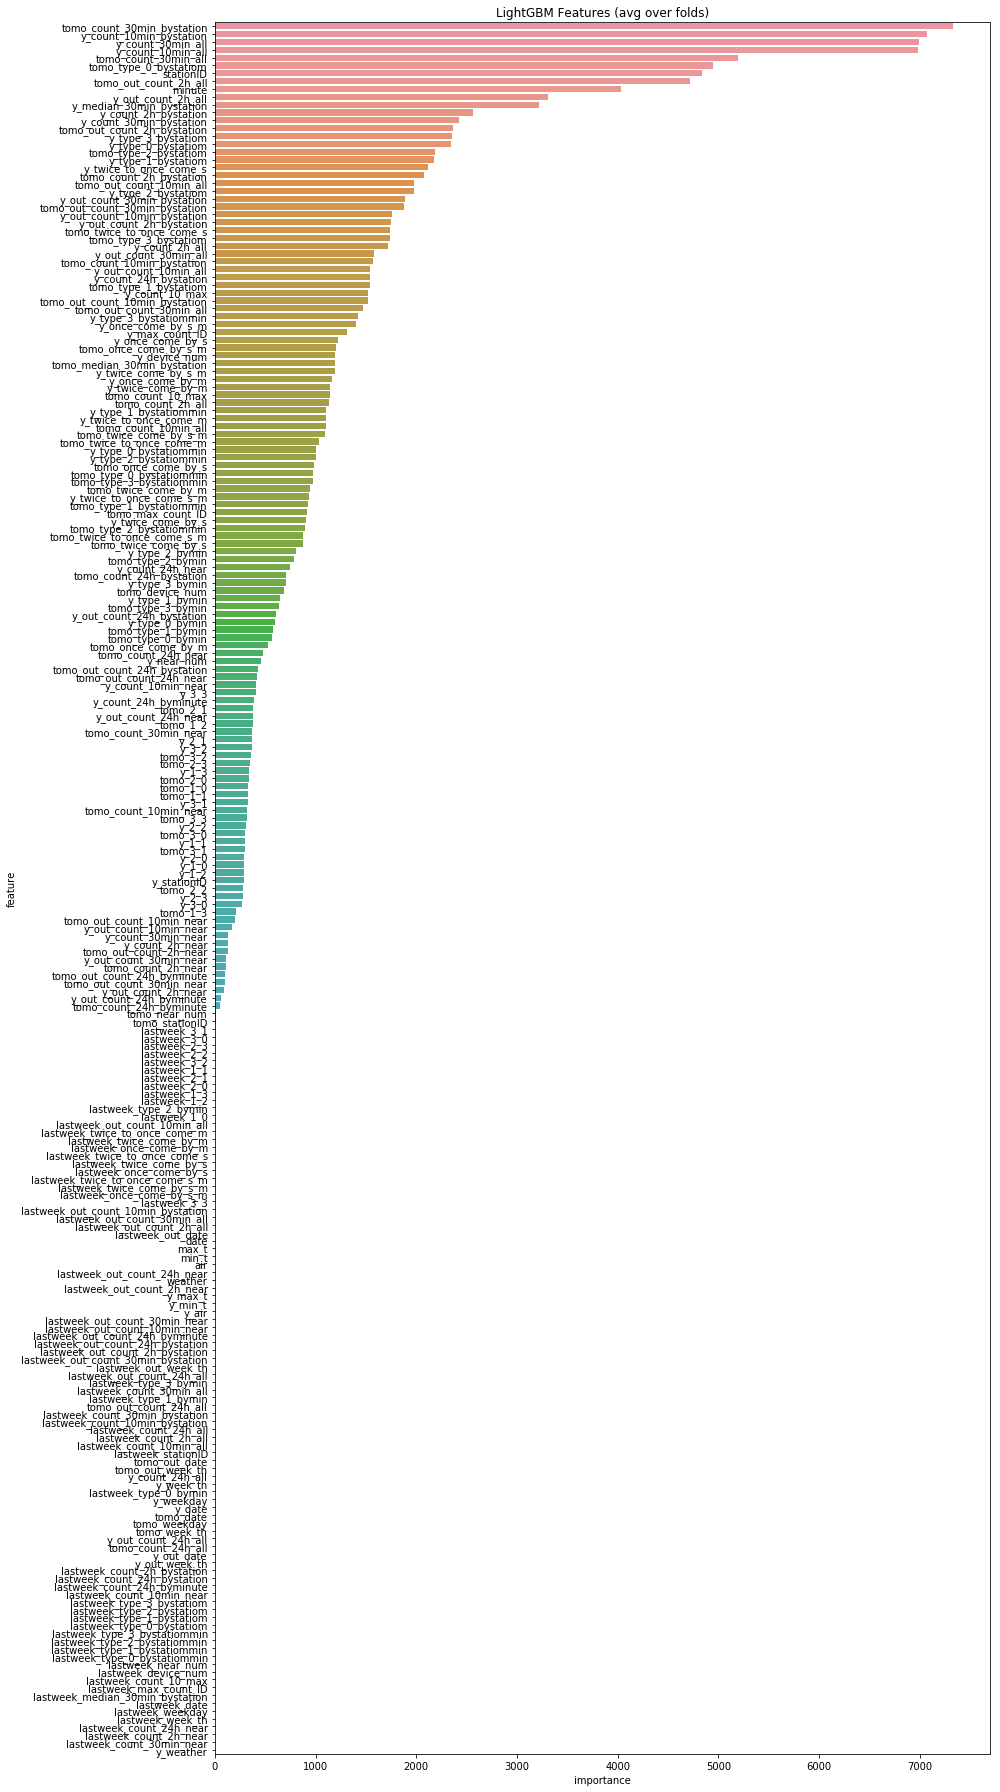

In [32]:
cols = (fold_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = fold_importance_df.loc[fold_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [126]:
# predict
train = one_day[(one_day.date.isin([3,4,8,9,10,11,15,16,17,18,22,23,24,25]))&(one_day.stationID!=54)]
trn_data = lgb.Dataset(train[predictor3],label=train['come_label'])
num_round = 3000
clf = lgb.train(param,trn_data,num_round)

In [127]:
test = one_day[(one_day.date==29)&(one_day.minute.isin(set(range(144))))]
y_pred = clf.predict(test[predictor3])
test['label']=y_pred
test[['minute','stationID','label']].to_pickle('come.pkl')